In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from nn_model import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5.5
n_thermalization_steps = 100
n_steps = 80
step_size = 0.1
n_iterations = 512

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC:   2%|▏         | 8/512 [00:00<00:13, 36.43it/s]

Norm of Force: 69.70771789550781


Running HMC:   3%|▎         | 17/512 [00:00<00:12, 38.93it/s]

Norm of Force: 67.85424041748047


Running HMC:   5%|▌         | 27/512 [00:00<00:12, 39.73it/s]

Norm of Force: 68.96882629394531


Running HMC:   7%|▋         | 37/512 [00:00<00:11, 40.01it/s]

Norm of Force: 76.75743103027344


Running HMC:   9%|▉         | 46/512 [00:01<00:11, 40.04it/s]

Norm of Force: 73.01506805419922


Running HMC:  11%|█         | 55/512 [00:01<00:11, 39.74it/s]

Norm of Force: 72.77598571777344


Running HMC:  13%|█▎        | 69/512 [00:01<00:11, 39.93it/s]

Norm of Force: 70.96800231933594


Running HMC:  15%|█▌        | 77/512 [00:01<00:11, 39.44it/s]

Norm of Force: 76.81708526611328


Running HMC:  17%|█▋        | 85/512 [00:02<00:10, 39.38it/s]

Norm of Force: 71.07069396972656


Running HMC:  19%|█▉        | 97/512 [00:02<00:10, 39.31it/s]

Norm of Force: 75.52167510986328


Running HMC:  21%|██        | 105/512 [00:02<00:10, 39.22it/s]

Norm of Force: 67.77901458740234


Running HMC:  23%|██▎       | 119/512 [00:03<00:09, 39.90it/s]

Norm of Force: 72.09934997558594


Running HMC:  25%|██▌       | 128/512 [00:03<00:09, 39.97it/s]

Norm of Force: 71.69124603271484


Running HMC:  27%|██▋       | 137/512 [00:03<00:09, 39.98it/s]

Norm of Force: 74.59613800048828


Running HMC:  29%|██▊       | 146/512 [00:03<00:09, 40.22it/s]

Norm of Force: 70.31892395019531


Running HMC:  30%|███       | 156/512 [00:03<00:08, 40.12it/s]

Norm of Force: 70.70806884765625


Running HMC:  32%|███▏      | 166/512 [00:04<00:08, 40.49it/s]

Norm of Force: 74.13744354248047


Running HMC:  34%|███▍      | 176/512 [00:04<00:08, 39.85it/s]

Norm of Force: 72.47269439697266


Running HMC:  37%|███▋      | 188/512 [00:04<00:08, 39.05it/s]

Norm of Force: 69.34264373779297


Running HMC:  38%|███▊      | 196/512 [00:04<00:08, 38.77it/s]

Norm of Force: 68.32780456542969


Running HMC:  41%|████      | 208/512 [00:05<00:07, 38.65it/s]

Norm of Force: 73.6751480102539


Running HMC:  42%|████▏     | 216/512 [00:05<00:07, 38.61it/s]

Norm of Force: 67.9818344116211


Running HMC:  45%|████▍     | 228/512 [00:05<00:07, 38.56it/s]

Norm of Force: 72.65543365478516


Running HMC:  46%|████▌     | 236/512 [00:05<00:07, 38.54it/s]

Norm of Force: 74.85377502441406


Running HMC:  48%|████▊     | 248/512 [00:06<00:06, 37.74it/s]

Norm of Force: 73.74479675292969


Running HMC:  50%|█████     | 256/512 [00:06<00:06, 38.10it/s]

Norm of Force: 76.35929870605469


Running HMC:  52%|█████▏    | 268/512 [00:06<00:06, 38.37it/s]

Norm of Force: 71.94002532958984


Running HMC:  54%|█████▍    | 276/512 [00:07<00:06, 38.43it/s]

Norm of Force: 69.63870239257812


Running HMC:  56%|█████▋    | 288/512 [00:07<00:05, 38.52it/s]

Norm of Force: 63.63352966308594


Running HMC:  58%|█████▊    | 296/512 [00:07<00:05, 38.51it/s]

Norm of Force: 69.90257263183594


Running HMC:  60%|██████    | 308/512 [00:07<00:05, 38.53it/s]

Norm of Force: 71.41102600097656


Running HMC:  62%|██████▏   | 316/512 [00:08<00:05, 38.41it/s]

Norm of Force: 66.25352478027344


Running HMC:  64%|██████▍   | 328/512 [00:08<00:04, 38.00it/s]

Norm of Force: 68.49658203125


Running HMC:  66%|██████▌   | 337/512 [00:08<00:04, 39.10it/s]

Norm of Force: 70.45938873291016


Running HMC:  68%|██████▊   | 346/512 [00:08<00:04, 39.64it/s]

Norm of Force: 74.71781921386719


Running HMC:  70%|██████▉   | 356/512 [00:09<00:03, 39.91it/s]

Norm of Force: 70.40935516357422


Running HMC:  71%|███████▏  | 366/512 [00:09<00:03, 40.06it/s]

Norm of Force: 74.6925048828125


Running HMC:  73%|███████▎  | 376/512 [00:09<00:03, 40.13it/s]

Norm of Force: 69.64456176757812


Running HMC:  75%|███████▌  | 386/512 [00:09<00:03, 40.15it/s]

Norm of Force: 73.55630493164062


Running HMC:  77%|███████▋  | 396/512 [00:10<00:02, 40.18it/s]

Norm of Force: 69.99324035644531


Running HMC:  79%|███████▉  | 406/512 [00:10<00:02, 39.40it/s]

Norm of Force: 70.6841049194336


Running HMC:  82%|████████▏ | 419/512 [00:10<00:02, 39.83it/s]

Norm of Force: 75.68179321289062


Running HMC:  84%|████████▎ | 428/512 [00:10<00:02, 39.96it/s]

Norm of Force: 64.49288177490234


Running HMC:  85%|████████▌ | 437/512 [00:11<00:01, 39.97it/s]

Norm of Force: 72.1622543334961


Running HMC:  87%|████████▋ | 446/512 [00:11<00:01, 40.05it/s]

Norm of Force: 73.71626281738281


Running HMC:  89%|████████▉ | 456/512 [00:11<00:01, 40.13it/s]

Norm of Force: 69.5647201538086


Running HMC:  91%|█████████ | 466/512 [00:11<00:01, 40.19it/s]

Norm of Force: 72.74846649169922


Running HMC:  93%|█████████▎| 476/512 [00:12<00:00, 40.22it/s]

Norm of Force: 66.98654174804688


Running HMC:  95%|█████████▍| 486/512 [00:12<00:00, 39.23it/s]

Norm of Force: 74.00342559814453


Running HMC:  97%|█████████▋| 496/512 [00:12<00:00, 39.71it/s]

Norm of Force: 70.66739654541016


Running HMC:  99%|█████████▉| 506/512 [00:12<00:00, 39.98it/s]

Norm of Force: 69.60710144042969


Running HMC: 100%|██████████| 512/512 [00:13<00:00, 39.32it/s]


Norm of Force: 69.18843078613281
>>> Simulation completed
>>> Mean plaq:  0.9030729129444808
>>> Std plaq:  0.008274325897831772


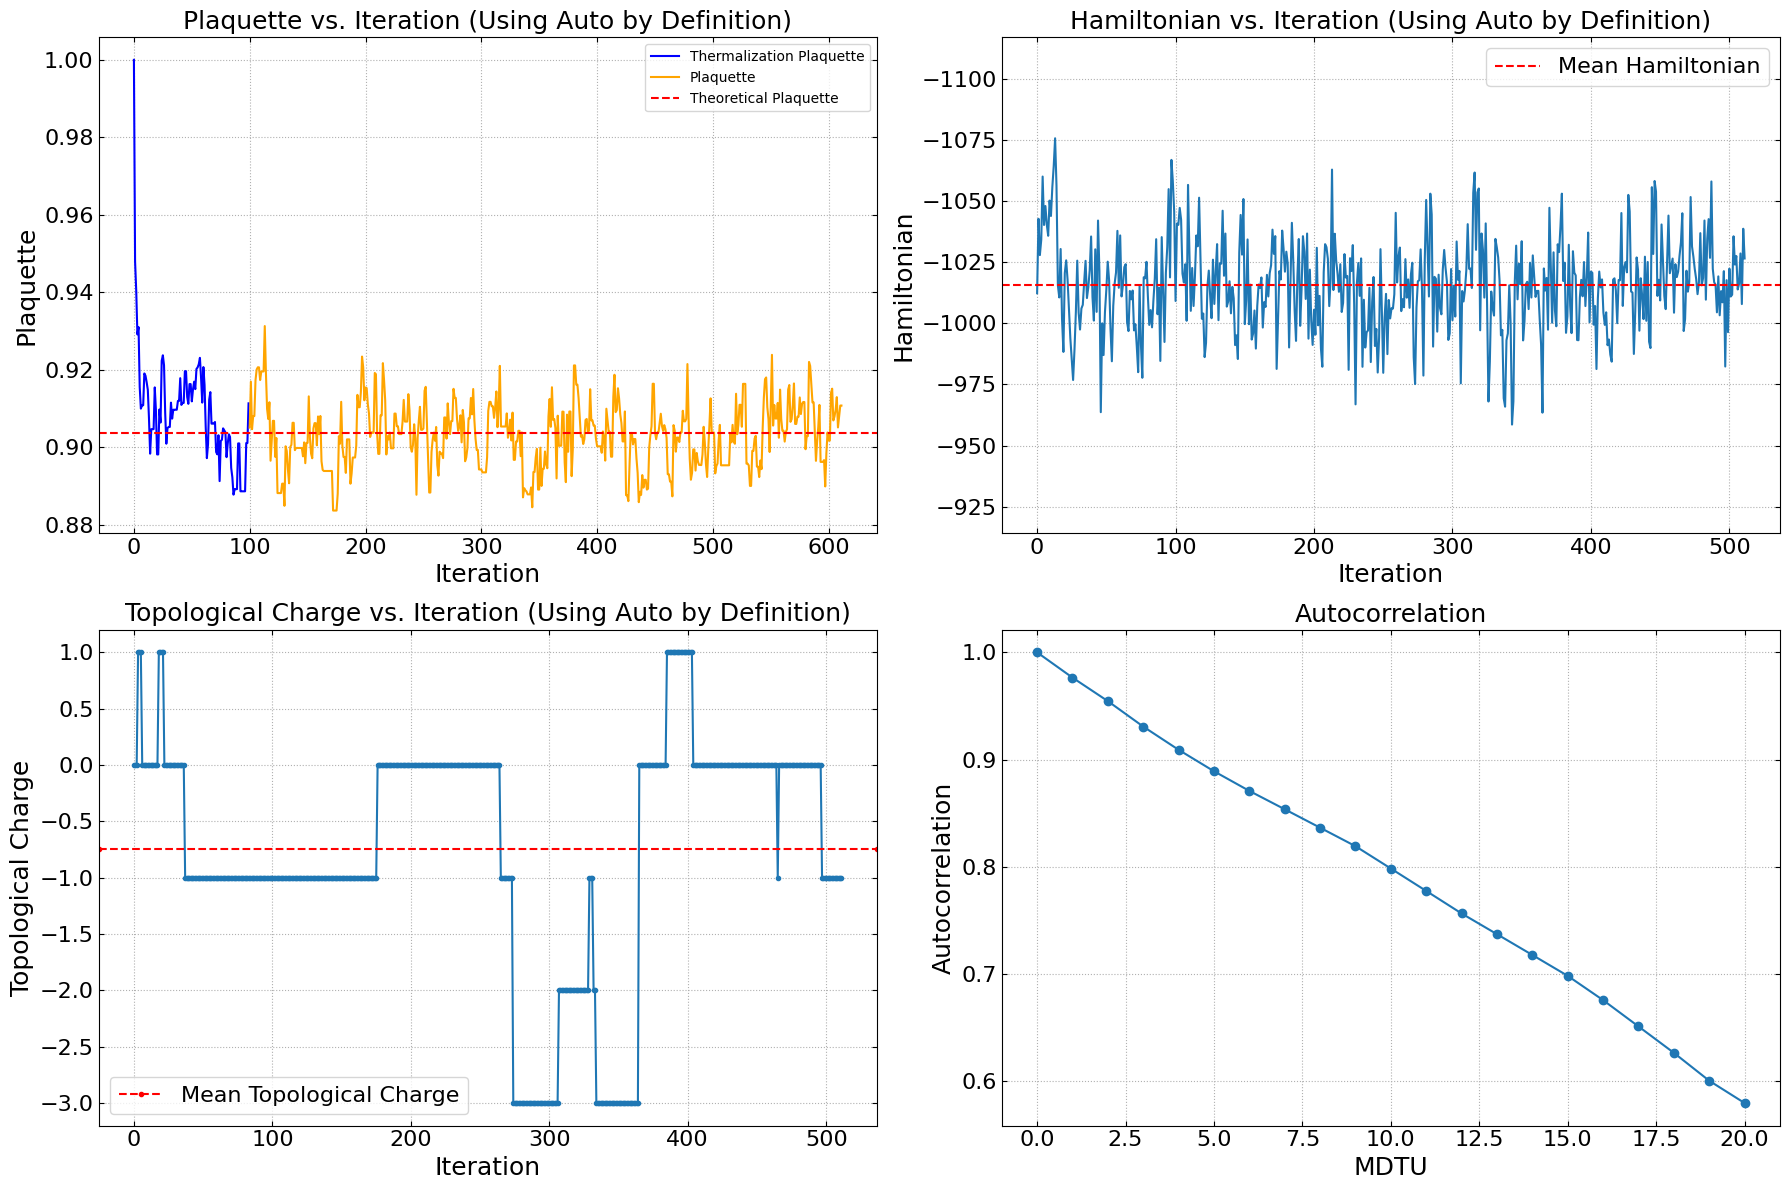

>>> Mean plaq:  0.9030729129444808
>>> Std plaq:  0.008274325897831772


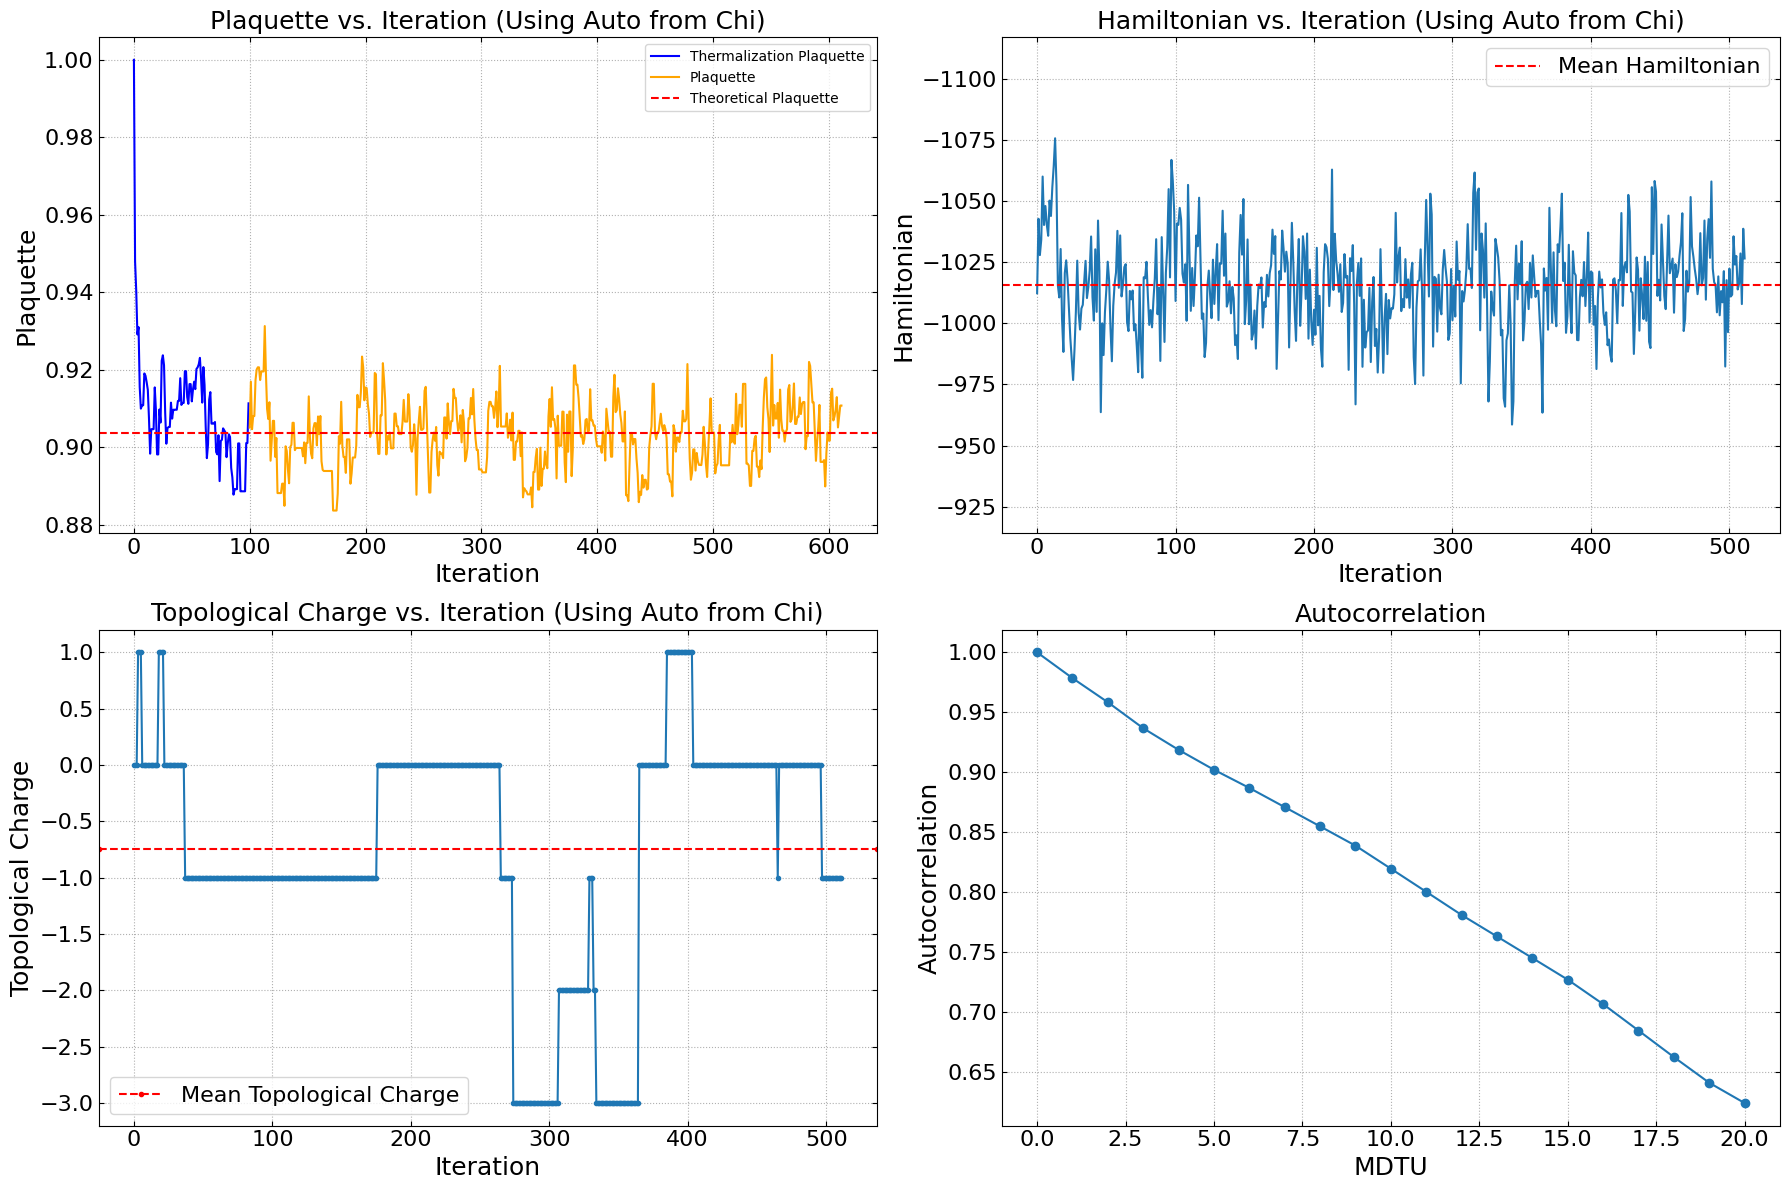

Thermalization acceptance rate: 0.7900
Acceptance rate: 0.7598


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Manual Field Transformation

Running HMC:   1%|          | 5/512 [00:04<05:37,  1.50it/s]

Norm of New Force: 75.64788818359375Norm of Old Force: 75.4386978149414


Running HMC:   3%|▎         | 17/512 [00:04<01:03,  7.85it/s]

Norm of New Force: 79.3956069946289Norm of Old Force: 79.28575134277344


Running HMC:   5%|▍         | 25/512 [00:04<00:34, 14.09it/s]

Norm of New Force: 73.25350952148438Norm of Old Force: 73.2701416015625


Running HMC:   7%|▋         | 37/512 [00:05<00:19, 23.77it/s]

Norm of New Force: 68.21014404296875Norm of Old Force: 68.48992919921875


Running HMC:   9%|▉         | 45/512 [00:05<00:16, 28.41it/s]

Norm of New Force: 68.39479064941406Norm of Old Force: 68.4273681640625


Running HMC:  11%|█         | 57/512 [00:05<00:14, 32.39it/s]

Norm of New Force: 74.18221282958984Norm of Old Force: 74.3127670288086


Running HMC:  12%|█▏        | 61/512 [00:06<00:13, 32.41it/s]

Norm of New Force: 67.05984497070312Norm of Old Force: 66.93855285644531


Running HMC:  15%|█▌        | 77/512 [00:10<01:02,  6.99it/s]

Norm of New Force: 68.30757141113281Norm of Old Force: 68.50496673583984


Running HMC:  17%|█▋        | 85/512 [00:11<00:36, 11.64it/s]

Norm of New Force: 69.99209594726562Norm of Old Force: 70.0339126586914


Running HMC:  19%|█▉        | 97/512 [00:11<00:20, 19.96it/s]

Norm of New Force: 69.3677978515625Norm of Old Force: 69.38591003417969


Running HMC:  21%|██        | 105/512 [00:11<00:16, 25.21it/s]

Norm of New Force: 79.46395111083984Norm of Old Force: 79.71212005615234


Running HMC:  23%|██▎       | 117/512 [00:12<00:13, 30.26it/s]

Norm of New Force: 77.0776596069336Norm of Old Force: 77.35356140136719


Running HMC:  24%|██▍       | 125/512 [00:12<00:12, 31.29it/s]

Norm of New Force: 74.40760803222656Norm of Old Force: 74.14427185058594


Running HMC:  27%|██▋       | 137/512 [00:16<01:09,  5.36it/s]

Norm of New Force: 74.26325988769531Norm of Old Force: 74.4374771118164


Running HMC:  28%|██▊       | 145/512 [00:17<00:39,  9.39it/s]

Norm of New Force: 74.3714370727539Norm of Old Force: 74.59241485595703


Running HMC:  31%|███       | 157/512 [00:17<00:19, 17.97it/s]

Norm of New Force: 75.47039031982422Norm of Old Force: 75.47525024414062


Running HMC:  32%|███▏      | 165/512 [00:17<00:14, 23.61it/s]

Norm of New Force: 75.10765075683594Norm of Old Force: 75.1614761352539


Running HMC:  35%|███▍      | 177/512 [00:18<00:11, 29.64it/s]

Norm of New Force: 74.57611846923828Norm of Old Force: 74.56429290771484


Running HMC:  36%|███▌      | 185/512 [00:18<00:10, 31.65it/s]

Norm of New Force: 76.58898162841797Norm of Old Force: 76.38875579833984


Running HMC:  37%|███▋      | 189/512 [00:18<00:10, 32.14it/s]

Norm of New Force: 73.56483459472656Norm of Old Force: 73.37202453613281


Running HMC:  40%|████      | 205/512 [00:22<00:38,  8.01it/s]

Norm of New Force: 69.78141021728516Norm of Old Force: 70.15557861328125


Running HMC:  42%|████▏     | 217/512 [00:23<00:18, 15.91it/s]

Norm of New Force: 70.49827575683594Norm of Old Force: 70.2202377319336


Running HMC:  44%|████▍     | 225/512 [00:23<00:13, 21.54it/s]

Norm of New Force: 72.74153900146484Norm of Old Force: 72.85482025146484


Running HMC:  46%|████▋     | 237/512 [00:23<00:09, 28.41it/s]

Norm of New Force: 76.33049011230469Norm of Old Force: 76.3560562133789


Running HMC:  48%|████▊     | 245/512 [00:23<00:08, 30.82it/s]

Norm of New Force: 71.81927490234375Norm of Old Force: 71.94622802734375


Running HMC:  49%|████▉     | 253/512 [00:24<00:08, 32.33it/s]

Norm of New Force: 69.24597930908203Norm of Old Force: 69.1168441772461


Running HMC:  52%|█████▏    | 265/512 [00:28<00:41,  6.02it/s]

Norm of New Force: 73.59148406982422Norm of Old Force: 73.66739654541016


Running HMC:  54%|█████▍    | 277/512 [00:28<00:17, 13.10it/s]

Norm of New Force: 70.85208892822266Norm of Old Force: 71.08474731445312


Running HMC:  56%|█████▌    | 285/512 [00:28<00:11, 19.16it/s]

Norm of New Force: 67.03773498535156Norm of Old Force: 67.2618637084961


Running HMC:  58%|█████▊    | 297/512 [00:29<00:08, 26.82it/s]

Norm of New Force: 69.45881652832031Norm of Old Force: 69.41007232666016


Running HMC:  60%|█████▉    | 305/512 [00:29<00:06, 30.35it/s]

Norm of New Force: 65.1260757446289Norm of Old Force: 65.2684097290039


Running HMC:  62%|██████▏   | 317/512 [00:29<00:05, 33.17it/s]

Norm of New Force: 71.18290710449219Norm of Old Force: 71.07938385009766


Running HMC:  63%|██████▎   | 325/512 [00:33<00:41,  4.49it/s]

Norm of New Force: 70.65967559814453Norm of Old Force: 70.80069732666016


Running HMC:  66%|██████▌   | 337/512 [00:33<00:16, 10.36it/s]

Norm of New Force: 63.003692626953125Norm of Old Force: 63.37450408935547


Running HMC:  67%|██████▋   | 345/512 [00:34<00:10, 15.90it/s]

Norm of New Force: 65.83647918701172Norm of Old Force: 65.57262420654297


Running HMC:  70%|██████▉   | 357/512 [00:34<00:06, 24.20it/s]

Norm of New Force: 71.46076202392578Norm of Old Force: 71.32323455810547


Running HMC:  71%|███████▏  | 365/512 [00:34<00:05, 27.95it/s]

Norm of New Force: 76.01361083984375Norm of Old Force: 76.08251953125


Running HMC:  74%|███████▎  | 377/512 [00:35<00:04, 31.07it/s]

Norm of New Force: 68.67007446289062Norm of Old Force: 68.73420715332031


Running HMC:  74%|███████▍  | 381/512 [00:35<00:04, 31.33it/s]

Norm of New Force: 67.10647583007812Norm of Old Force: 66.84861755371094


Running HMC:  78%|███████▊  | 397/512 [00:39<00:14,  7.79it/s]

Norm of New Force: 69.45918273925781Norm of Old Force: 69.45658874511719


Running HMC:  79%|███████▉  | 405/512 [00:39<00:08, 12.75it/s]

Norm of New Force: 72.25191497802734Norm of Old Force: 72.3294677734375


Running HMC:  81%|████████▏ | 417/512 [00:40<00:04, 21.31it/s]

Norm of New Force: 65.84654998779297Norm of Old Force: 66.07646942138672


Running HMC:  83%|████████▎ | 425/512 [00:40<00:03, 25.95it/s]

Norm of New Force: 72.70274353027344Norm of Old Force: 72.80751037597656


Running HMC:  85%|████████▌ | 437/512 [00:40<00:02, 30.08it/s]

Norm of New Force: 74.19586181640625Norm of Old Force: 74.43144989013672


Running HMC:  87%|████████▋ | 445/512 [00:40<00:02, 31.42it/s]

Norm of New Force: 71.37847137451172Norm of Old Force: 71.51611328125


Running HMC:  89%|████████▉ | 457/512 [00:45<00:09,  5.85it/s]

Norm of New Force: 70.85671997070312Norm of Old Force: 70.77116394042969


Running HMC:  91%|█████████ | 465/512 [00:45<00:04, 10.02it/s]

Norm of New Force: 74.37737274169922Norm of Old Force: 74.51776885986328


Running HMC:  93%|█████████▎| 477/512 [00:45<00:01, 18.49it/s]

Norm of New Force: 72.09288024902344Norm of Old Force: 72.05065155029297


Running HMC:  95%|█████████▍| 485/512 [00:46<00:01, 23.79it/s]

Norm of New Force: 70.1572494506836Norm of Old Force: 69.91253662109375


Running HMC:  97%|█████████▋| 497/512 [00:46<00:00, 29.04it/s]

Norm of New Force: 67.13048553466797Norm of Old Force: 67.18587493896484


Running HMC:  99%|█████████▊| 505/512 [00:46<00:00, 30.81it/s]

Norm of New Force: 71.08049011230469Norm of Old Force: 70.9077377319336


Running HMC: 100%|██████████| 512/512 [00:46<00:00, 10.93it/s]


Norm of New Force: 71.04788970947266Norm of Old Force: 70.86112976074219
>>> Simulation completed
>>> Mean plaq:  0.9035252099856734
>>> Std plaq:  0.008826241036577693


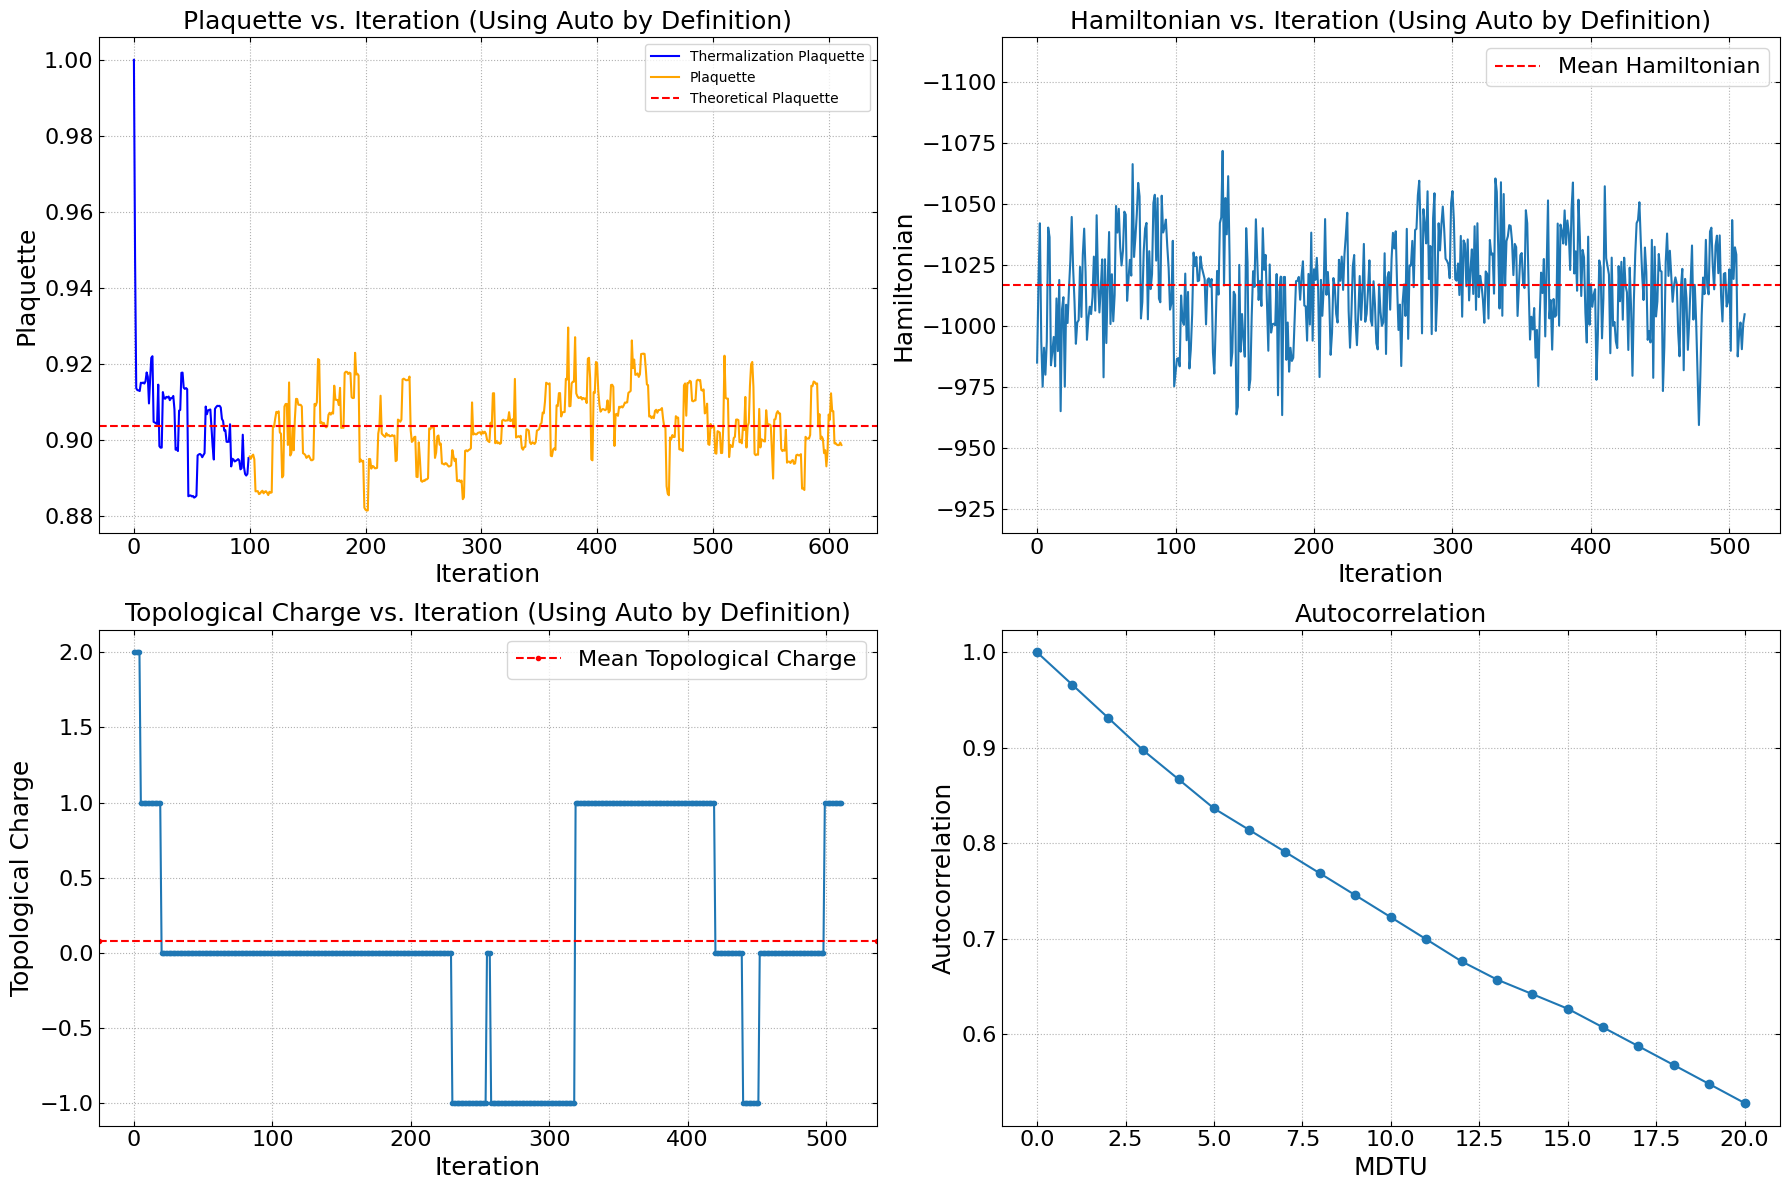

>>> Mean plaq:  0.9035252099856734
>>> Std plaq:  0.008826241036577693


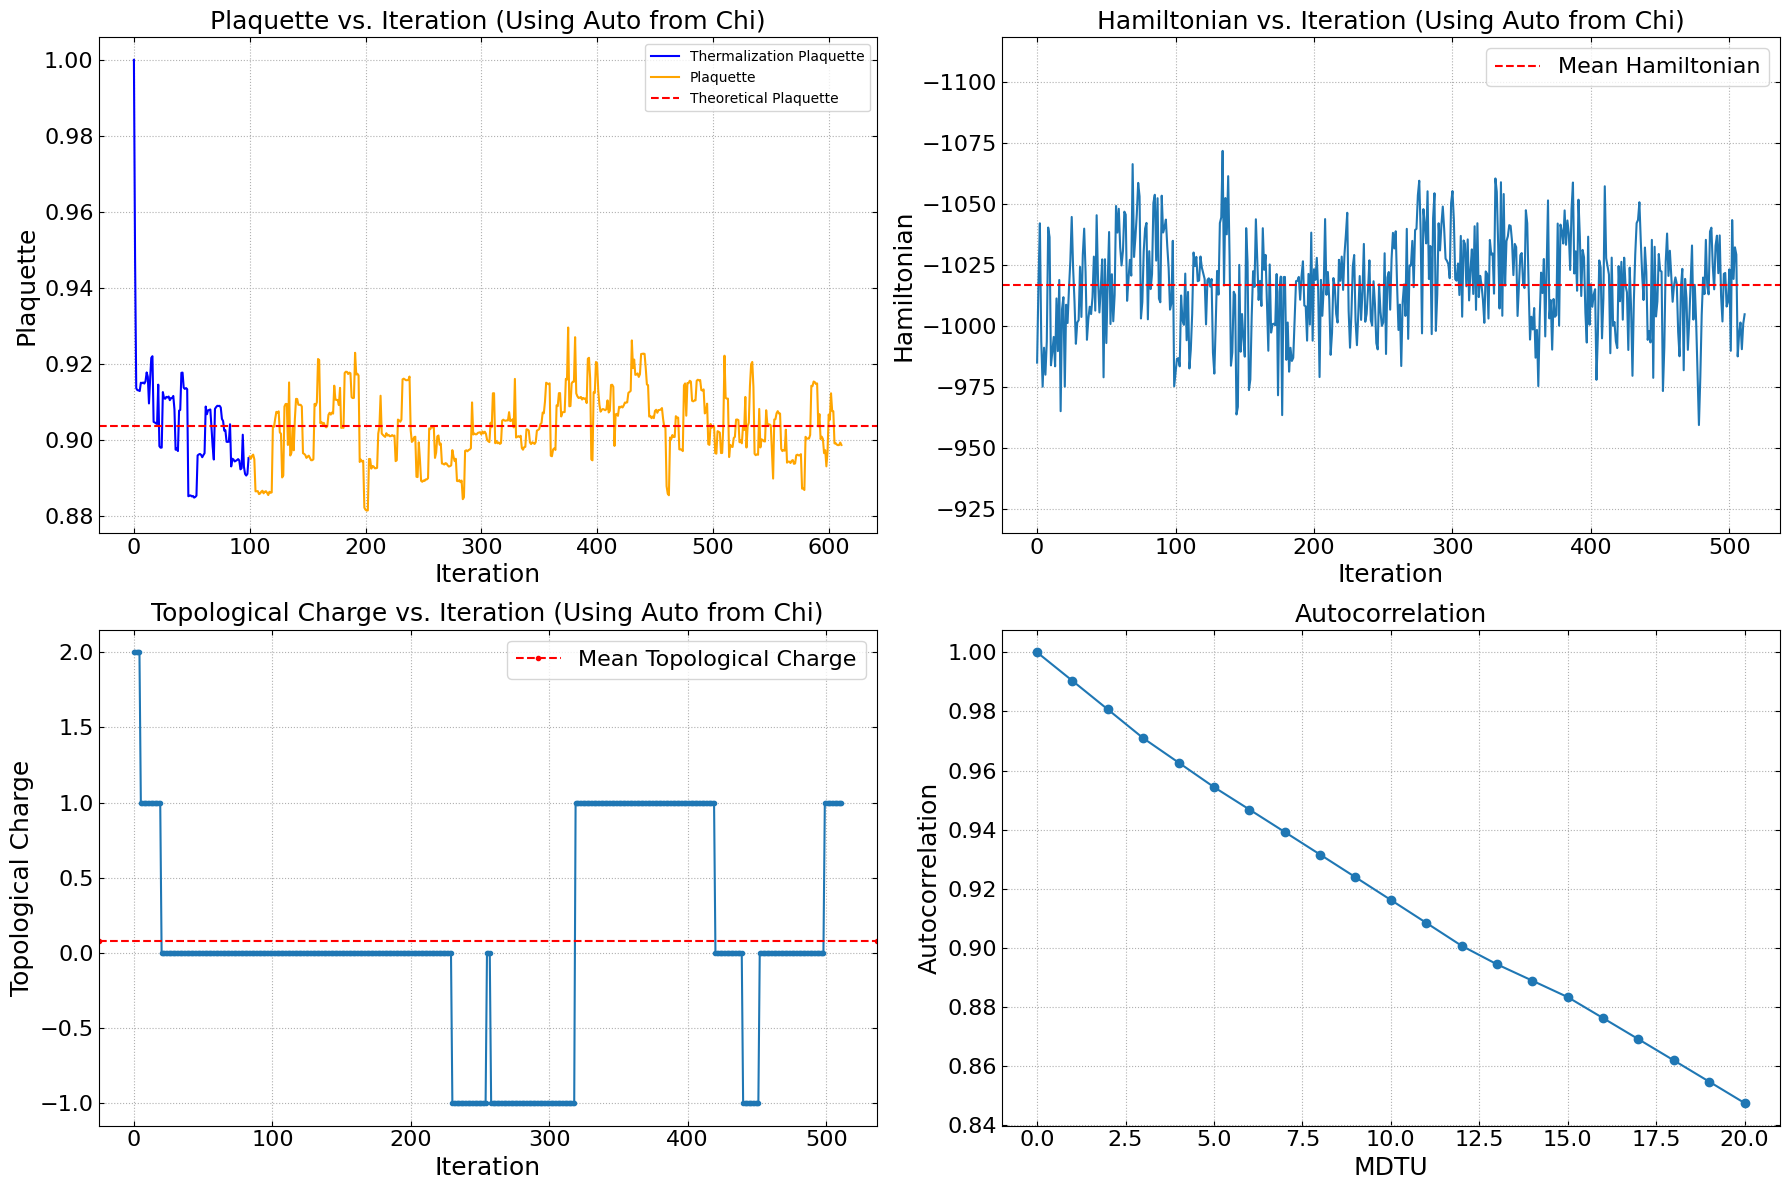

Thermalization acceptance rate: 0.4200
Acceptance rate: 0.3887


In [4]:
def manual_transformation(U, epsilon=0.005):
    noise = epsilon * (torch.randn_like(U) + 0.5)
    return U + noise

# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=manual_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")

# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network:   0%|          | 0/200 [00:00<?, ?it/s]

Training Neural Network: 100%|██████████| 200/200 [00:03<00:00, 65.53it/s]


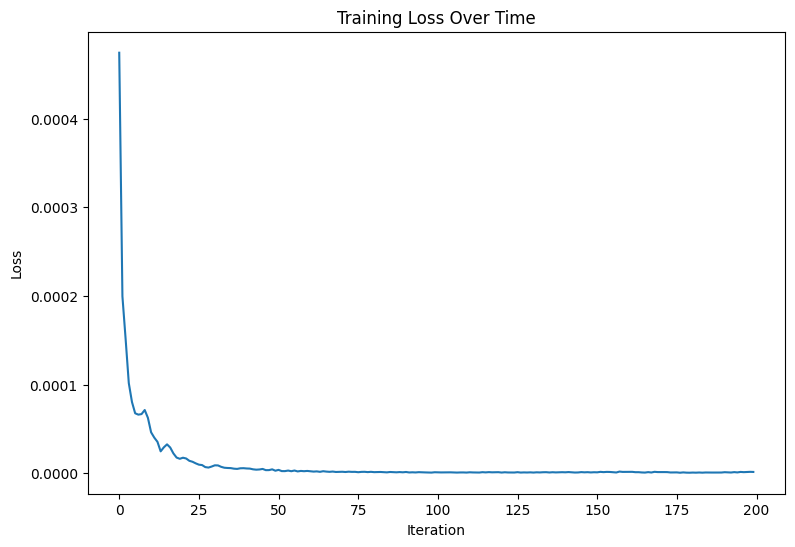


Neural Network Field Transformation Structure:
CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Running HMC:   1%|          | 3/512 [00:14<31:12,  3.68s/it]  

Norm of New Force: 71.59735870361328Norm of Old Force: 71.62115478515625


Running HMC:   3%|▎         | 13/512 [00:14<02:51,  2.91it/s]

Norm of New Force: 63.89447784423828Norm of Old Force: 63.91790771484375


Running HMC:   4%|▍         | 23/512 [00:15<00:55,  8.81it/s]

Norm of New Force: 68.49541473388672Norm of Old Force: 68.46240997314453


Running HMC:   6%|▋         | 33/512 [00:16<00:41, 11.47it/s]

Norm of New Force: 70.07271575927734Norm of Old Force: 70.10771179199219


Running HMC:   8%|▊         | 43/512 [00:17<00:34, 13.72it/s]

Norm of New Force: 70.61767578125Norm of Old Force: 70.59197998046875


Running HMC:  10%|█         | 53/512 [00:17<00:32, 14.34it/s]

Norm of New Force: 70.304931640625Norm of Old Force: 70.29813385009766


Running HMC:  12%|█▏        | 63/512 [00:18<00:30, 14.54it/s]

Norm of New Force: 71.45874786376953Norm of Old Force: 71.46470642089844


Running HMC:  14%|█▍        | 73/512 [00:32<03:56,  1.86it/s]

Norm of New Force: 68.59696960449219Norm of Old Force: 68.64117431640625


Running HMC:  16%|█▌        | 83/512 [00:32<01:03,  6.74it/s]

Norm of New Force: 68.63672637939453Norm of Old Force: 68.63294219970703


Running HMC:  18%|█▊        | 93/512 [00:33<00:35, 11.78it/s]

Norm of New Force: 72.6250991821289Norm of Old Force: 72.65641784667969


Running HMC:  20%|██        | 103/512 [00:34<00:29, 13.81it/s]

Norm of New Force: 69.5255355834961Norm of Old Force: 69.55859375


Running HMC:  22%|██▏       | 113/512 [00:34<00:28, 14.22it/s]

Norm of New Force: 72.60301971435547Norm of Old Force: 72.63300323486328


Running HMC:  24%|██▍       | 123/512 [00:35<00:27, 14.07it/s]

Norm of New Force: 72.36166381835938Norm of Old Force: 72.40457916259766


Running HMC:  26%|██▌       | 132/512 [00:49<07:28,  1.18s/it]

Norm of New Force: 75.95796203613281Norm of Old Force: 75.97189331054688


Running HMC:  28%|██▊       | 142/512 [00:50<01:30,  4.10it/s]

Norm of New Force: 70.26588439941406Norm of Old Force: 70.3243408203125


Running HMC:  30%|██▉       | 152/512 [00:51<00:35, 10.18it/s]

Norm of New Force: 71.9875717163086Norm of Old Force: 72.02583312988281


Running HMC:  32%|███▏      | 162/512 [00:51<00:25, 13.60it/s]

Norm of New Force: 74.68328094482422Norm of Old Force: 74.72933959960938


Running HMC:  34%|███▎      | 172/512 [00:52<00:24, 14.11it/s]

Norm of New Force: 70.61553955078125Norm of Old Force: 70.66255187988281


Running HMC:  36%|███▌      | 182/512 [00:53<00:23, 14.32it/s]

Norm of New Force: 71.44353485107422Norm of Old Force: 71.45466613769531


Running HMC:  38%|███▊      | 192/512 [00:54<00:22, 14.33it/s]

Norm of New Force: 68.81689453125Norm of Old Force: 68.80680847167969


Running HMC:  39%|███▉      | 202/512 [01:06<02:35,  2.00it/s]

Norm of New Force: 69.83074188232422Norm of Old Force: 69.84281921386719


Running HMC:  41%|████▏     | 212/512 [01:07<00:42,  6.99it/s]

Norm of New Force: 67.52930450439453Norm of Old Force: 67.52717590332031


Running HMC:  43%|████▎     | 222/512 [01:08<00:23, 12.14it/s]

Norm of New Force: 71.59656524658203Norm of Old Force: 71.63136291503906


Running HMC:  45%|████▌     | 232/512 [01:08<00:20, 13.72it/s]

Norm of New Force: 75.73182678222656Norm of Old Force: 75.74562072753906


Running HMC:  47%|████▋     | 242/512 [01:09<00:19, 13.90it/s]

Norm of New Force: 69.43795013427734Norm of Old Force: 69.45860290527344


Running HMC:  49%|████▉     | 252/512 [01:10<00:18, 13.95it/s]

Norm of New Force: 72.90713500976562Norm of Old Force: 72.94537353515625


Running HMC:  51%|█████     | 262/512 [01:22<03:55,  1.06it/s]

Norm of New Force: 76.24597930908203Norm of Old Force: 76.24007415771484


Running HMC:  53%|█████▎    | 272/512 [01:23<00:51,  4.62it/s]

Norm of New Force: 72.44352722167969Norm of Old Force: 72.45555114746094


Running HMC:  55%|█████▌    | 282/512 [01:24<00:21, 10.59it/s]

Norm of New Force: 65.54890441894531Norm of Old Force: 65.55107116699219


Running HMC:  57%|█████▋    | 292/512 [01:24<00:16, 13.53it/s]

Norm of New Force: 70.48200988769531Norm of Old Force: 70.46994018554688


Running HMC:  59%|█████▉    | 302/512 [01:25<00:14, 14.11it/s]

Norm of New Force: 71.67445373535156Norm of Old Force: 71.70841979980469


Running HMC:  61%|██████    | 312/512 [01:26<00:13, 14.30it/s]

Norm of New Force: 70.90079498291016Norm of Old Force: 70.89998626708984


Running HMC:  63%|██████▎   | 322/512 [01:39<06:09,  1.94s/it]

Norm of New Force: 66.45388793945312Norm of Old Force: 66.50390625


Running HMC:  65%|██████▍   | 331/512 [01:40<01:16,  2.36it/s]

Norm of New Force: 70.97150421142578Norm of Old Force: 70.97293090820312


Running HMC:  67%|██████▋   | 342/512 [01:41<00:22,  7.61it/s]

Norm of New Force: 69.48143005371094Norm of Old Force: 69.51563262939453


Running HMC:  69%|██████▉   | 352/512 [01:42<00:17,  9.27it/s]

Norm of New Force: 69.80070495605469Norm of Old Force: 69.84369659423828


Running HMC:  71%|███████   | 362/512 [01:43<00:16,  9.16it/s]

Norm of New Force: 76.36727142333984Norm of Old Force: 76.38334655761719


Running HMC:  73%|███████▎  | 372/512 [01:44<00:14,  9.35it/s]

Norm of New Force: 72.71728515625Norm of Old Force: 72.7605972290039


Running HMC:  75%|███████▍  | 382/512 [01:45<00:14,  9.23it/s]

Norm of New Force: 75.0362777709961Norm of Old Force: 75.06834411621094


Running HMC:  77%|███████▋  | 392/512 [02:00<00:53,  2.26it/s]

Norm of New Force: 72.3994140625Norm of Old Force: 72.41349029541016


Running HMC:  79%|███████▊  | 402/512 [02:01<00:11,  9.41it/s]

Norm of New Force: 73.54164123535156Norm of Old Force: 73.58827209472656


Running HMC:  80%|████████  | 412/512 [02:02<00:07, 13.23it/s]

Norm of New Force: 73.64790344238281Norm of Old Force: 73.67916870117188


Running HMC:  82%|████████▏ | 422/512 [02:02<00:06, 14.04it/s]

Norm of New Force: 70.84557342529297Norm of Old Force: 70.87064361572266


Running HMC:  84%|████████▍ | 432/512 [02:03<00:05, 14.18it/s]

Norm of New Force: 73.35257720947266Norm of Old Force: 73.38736724853516


Running HMC:  86%|████████▋ | 442/512 [02:04<00:04, 14.28it/s]

Norm of New Force: 77.23873138427734Norm of Old Force: 77.26311492919922


Running HMC:  88%|████████▊ | 452/512 [02:18<01:27,  1.45s/it]

Norm of New Force: 71.38965606689453Norm of Old Force: 71.4270248413086


Running HMC:  90%|█████████ | 462/512 [02:18<00:15,  3.30it/s]

Norm of New Force: 71.95743560791016Norm of Old Force: 72.00039672851562


Running HMC:  92%|█████████▏| 472/512 [02:19<00:04,  9.11it/s]

Norm of New Force: 70.88815307617188Norm of Old Force: 70.88212585449219


Running HMC:  94%|█████████▍| 482/512 [02:20<00:02, 13.02it/s]

Norm of New Force: 75.75189208984375Norm of Old Force: 75.76029205322266


Running HMC:  96%|█████████▌| 492/512 [02:20<00:01, 14.11it/s]

Norm of New Force: 69.32661437988281Norm of Old Force: 69.33307647705078


Running HMC:  98%|█████████▊| 502/512 [02:21<00:00, 14.03it/s]

Norm of New Force: 72.44124603271484Norm of Old Force: 72.46674346923828


Running HMC: 100%|██████████| 512/512 [02:22<00:00,  3.60it/s]


Norm of New Force: 71.0632553100586Norm of Old Force: 71.08062744140625
>>> Simulation completed
>>> Mean plaq:  0.9043688427191228
>>> Std plaq:  0.00838173920890283


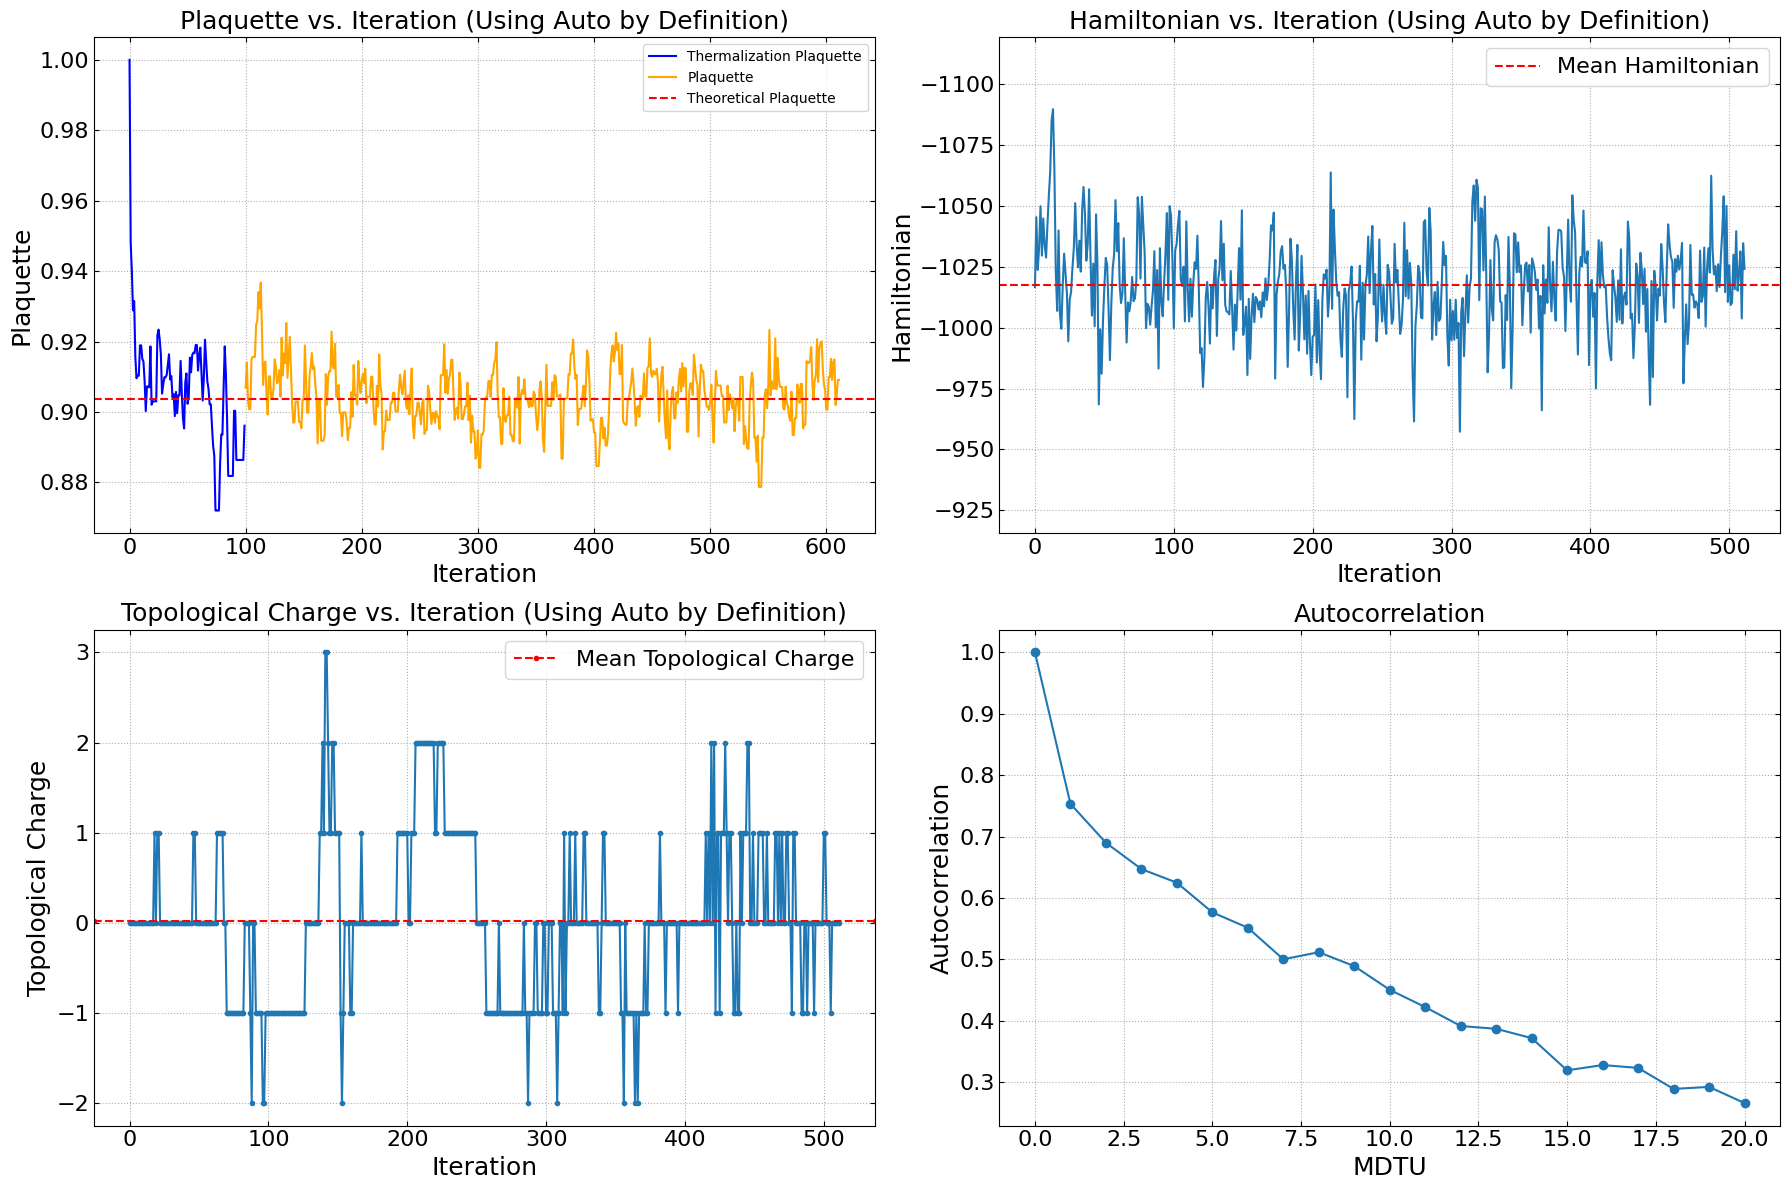

>>> Mean plaq:  0.9043688427191228
>>> Std plaq:  0.00838173920890283


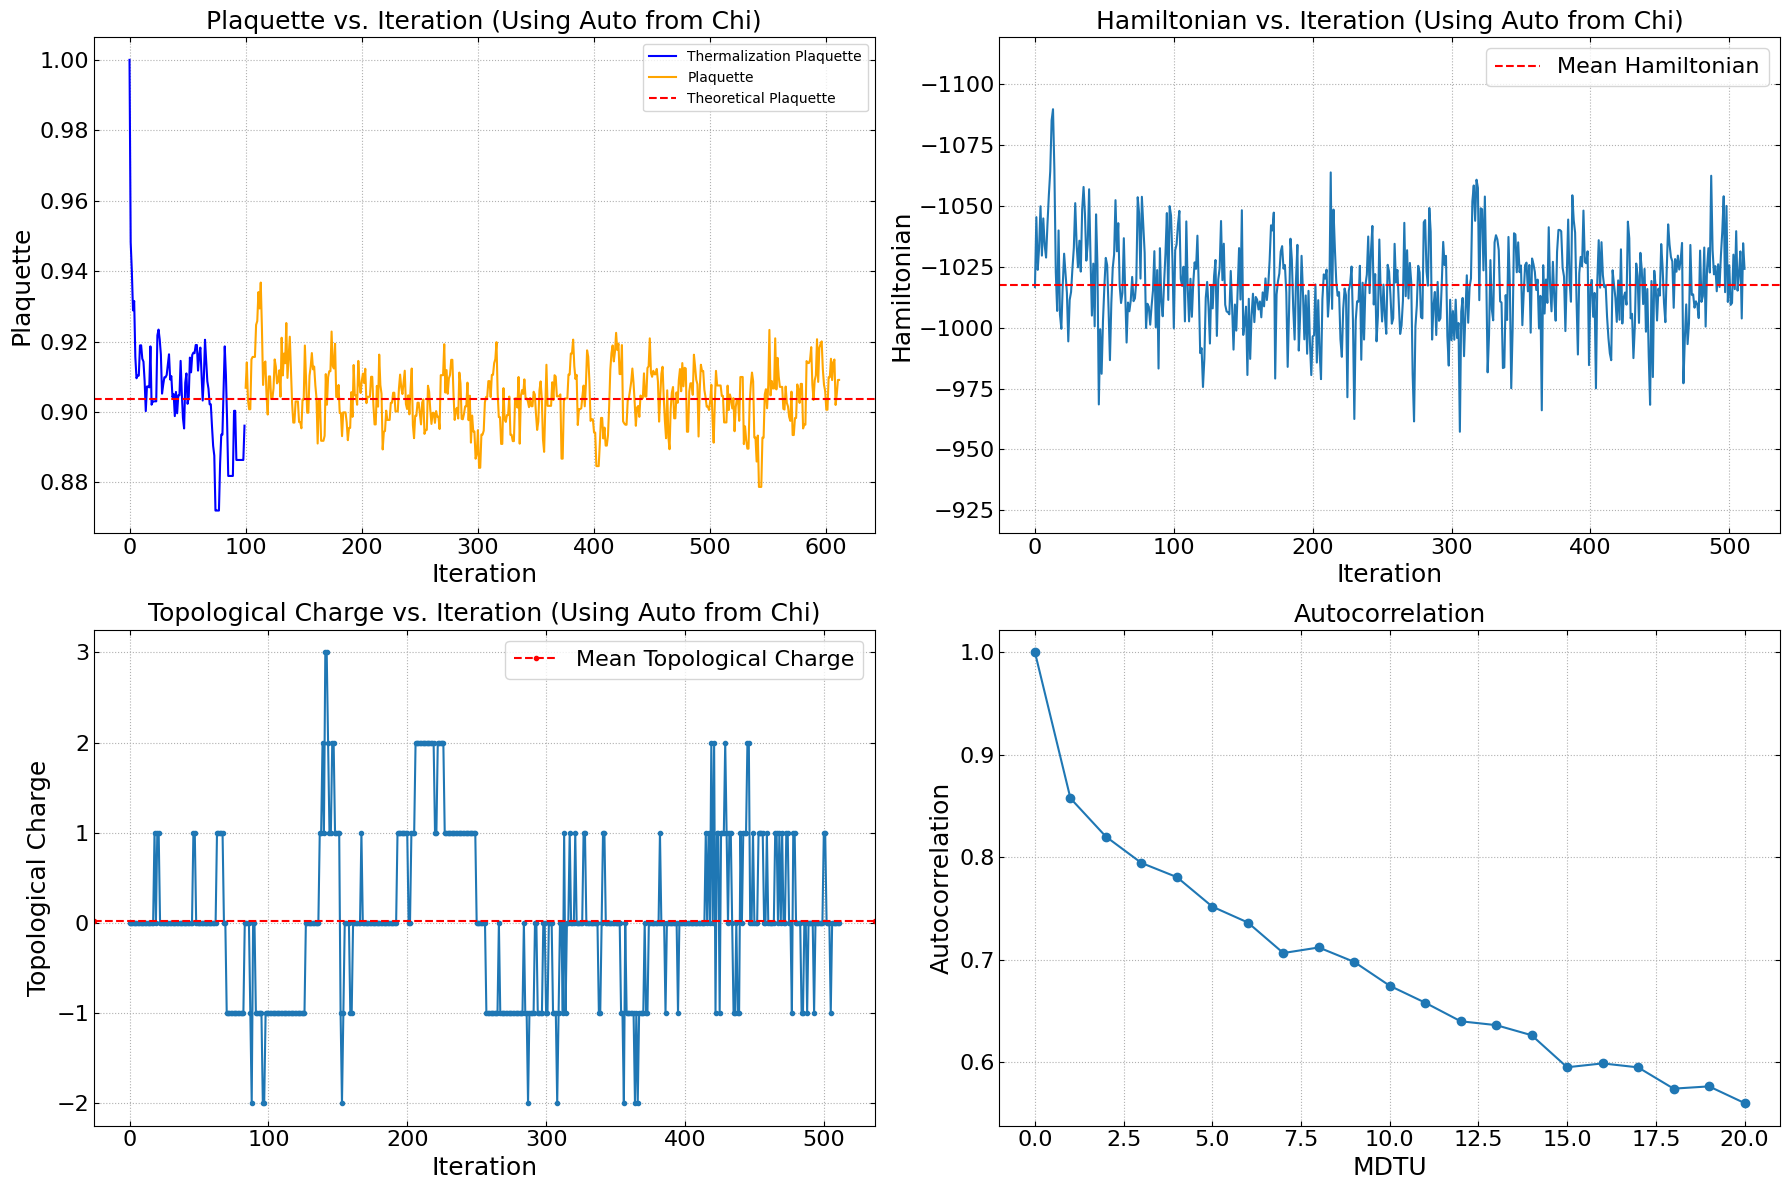

Thermalization acceptance rate: 0.7600
Acceptance rate: 0.8027


In [5]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN', epsilon=0.1, epsilon_decay=1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_iterations=200)

# Print the trained neural network structure and parameters
print("\nNeural Network Field Transformation Structure:")
print(nn_transformation.model)


# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

In [6]:
from jacobian import compute_jacobian_log_det

U_ini = torch.ones([2, lattice_size, lattice_size])
U_trans = nn_transformation.model(U_ini)

print(U_trans)
print(">>> Jacobian", compute_jacobian_log_det(U_ini, nn_transformation))


tensor([[-3.6814e-02, -3.5600e-02, -2.9807e-02, -3.0300e-02, -3.0300e-02,
         -3.0300e-02, -3.0300e-02, -3.0300e-02, -3.0300e-02, -3.0300e-02,
         -3.0300e-02, -3.0300e-02, -3.0300e-02, -2.1996e-02, -2.3934e-02,
         -1.0155e-02, -5.2479e-02, -4.7913e-02, -4.2488e-02, -4.5729e-02,
         -4.5729e-02, -4.5729e-02, -4.5729e-02, -4.5729e-02, -4.5729e-02,
         -4.5729e-02, -4.5729e-02, -4.5729e-02, -4.5729e-02, -4.2814e-02,
         -4.4552e-02, -2.7902e-02, -3.3955e-02, -3.8126e-02, -3.9851e-02,
         -4.5758e-02, -4.5758e-02, -4.5758e-02, -4.5758e-02, -4.5758e-02,
         -4.5758e-02, -4.5758e-02, -4.5758e-02, -4.5758e-02, -4.5758e-02,
         -3.8577e-02, -5.0948e-02, -4.1419e-02, -2.8939e-02, -3.1663e-02,
         -3.4240e-02, -4.0366e-02, -4.0366e-02, -4.0366e-02, -4.0366e-02,
         -4.0366e-02, -4.0366e-02, -4.0366e-02, -4.0366e-02, -4.0366e-02,
         -4.0366e-02, -3.5750e-02, -4.6748e-02, -4.1216e-02, -2.8939e-02,
         -3.1663e-02, -3.4240e-02, -4.

In [7]:
U_ini = torch.zeros([2, lattice_size, lattice_size])
# U_trans = manual_transformation(U_ini)
U_trans = nn_transformation(U_ini)

print(U_trans)
print(">>> Jacobian", compute_jacobian_log_det(U_ini, nn_transformation))


tensor([[[-3.1815e-03, -3.3755e-03, -3.2589e-03, -3.2589e-03, -3.2589e-03,
          -3.2589e-03, -3.2589e-03, -3.2589e-03, -3.2589e-03, -3.2589e-03,
          -3.2589e-03, -3.2589e-03, -3.2589e-03, -3.2589e-03, -3.2778e-03,
          -3.4084e-03],
         [-3.5820e-03, -3.7045e-03, -3.7863e-03, -3.7863e-03, -3.7863e-03,
          -3.7863e-03, -3.7863e-03, -3.7863e-03, -3.7863e-03, -3.7863e-03,
          -3.7863e-03, -3.7863e-03, -3.7863e-03, -3.7863e-03, -3.8152e-03,
          -3.7487e-03],
         [-3.5541e-03, -3.5188e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03,
          -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03,
          -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5348e-03,
          -3.5491e-03],
         [-3.5541e-03, -3.5188e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03,
          -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03,
          -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5043e-03, -3.5348e-03,
          -3.5491e-03],
    

torch.Size([2, 16, 16, 2, 16, 16])
torch.Size([512, 512])
>>> Jacobian tensor(0.0150, device='cuda:0')
